### Design Exploration and Optimization with Surrogate Physics Models

**Team Name:** *IITD*

**Team Members:**
- Member 1: Rishabh Jain
- Member 2: Shiv Ratn

**University:** Indian Institute of Technology, Delhi

In [21]:
# Imports & Config
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import time
import os

# Reproducibility
# np.random.seed(0)
# torch.manual_seed(0)
SEED = 10
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True)
except Exception:
    pass

# Data path
CSV_PATH = "data.csv"
df = pd.read_csv(CSV_PATH)

required = ["Velocity Inlet", "X Cell Size", "YZ Cell Size",
            "AvgVelocity", "Mass", "PressureDrop", "Surface Area"]
assert all(c in df.columns for c in required), "CSV missing required columns."


In [22]:
# Utilities
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def build_mlp(input_dim, output_dim, hidden_layers, activation=nn.ReLU()):
    layers = []
    prev_dim = input_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev_dim, h))
        layers.append(activation)
        prev_dim = h
    layers.append(nn.Linear(prev_dim, output_dim))
    return nn.Sequential(*layers)

### 🤖 Model Wrappers

Defines two neural network model wrappers:

- 🏋️ **Model1Wrapper**: Predicts **Mass** and **Surface Area** from **X Cell Size** and **YZ Cell Size**.
- 💨 **Model2Wrapper**: Predicts **AvgVelocity** and **PressureDrop** using cell sizes, inlet velocity, and Model 1 outputs.

Both wrappers include data preparation, model building, training, evaluation, and prediction methods. 🚀


In [23]:
# Model1 Wrapper
class Model1Wrapper:
    def __init__(self):
        self.model = None
        self.x_scaler = None
        self.y_scaler = None

    def prepare_data(self, df):
        X = df[["X Cell Size", "YZ Cell Size"]].values.astype(float)
        y = df[["Mass", "Surface Area"]].values.astype(float)
        # Split train/val/test: 75/15/10
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.01, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
        # scalers
        self.x_scaler = StandardScaler().fit(X_train)
        self.y_scaler = StandardScaler().fit(y_train)
        return (self.x_scaler.transform(X_train), self.y_scaler.transform(y_train),
                self.x_scaler.transform(X_val),   self.y_scaler.transform(y_val),
                self.x_scaler.transform(X_test),  self.y_scaler.transform(y_test))

    def build_model(self):
        # Define layers according to best params
        layers = [237, 182, 240]  # 3 layers
        activation = nn.LeakyReLU()  # as per best params
        self.model = build_mlp(2, 2, layers, activation=activation).to(DEVICE)

        # optimizer and lr as per best params
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0067455563692822771)
        self.loss_fn = nn.MSELoss()



    def fit(self, X_train, y_train, epochs=500):
        X_tr = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
        y_tr = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
        for ep in range(epochs):
            self.model.train()
            self.optimizer.zero_grad()
            preds = self.model(X_tr)
            loss = self.loss_fn(preds, y_tr)
            loss.backward()
            self.optimizer.step()

    def evaluate(self, X, y, label="set"):
        Xt = torch.tensor(X, dtype=torch.float32, device=DEVICE)
        self.model.eval()
        with torch.no_grad():
            preds = self.model(Xt).cpu().numpy()
        preds = self.y_scaler.inverse_transform(preds)
        y_true = self.y_scaler.inverse_transform(y)
        print(f"\nModel1 on {label}:")
        for i, name in enumerate(["Mass", "Surface Area"]):
            print(f"{name:15s} RMSE {rmse(y_true[:, i], preds[:, i]):.3f} | R2 {r2_score(y_true[:, i], preds[:, i]):.3f}")
        return preds

    def predict(self, x, yz):
        xin = np.array([[x, yz]], dtype=float)
        xs = self.x_scaler.transform(xin)
        xt = torch.tensor(xs, dtype=torch.float32, device=DEVICE)
        self.model.eval()
        with torch.no_grad():
            out_s = self.model(xt).cpu().numpy()
        vals = self.y_scaler.inverse_transform(out_s)[0]
        # Convert to native Python float for clean printing
        return {"mass": float(vals[0]), "surface_area": float(vals[1])}


In [24]:
# Model2 Wrapper
class Model2Wrapper:
    def __init__(self, model1):
        self.model1 = model1
        self.model = None
        self.x_scaler = None
        self.y_scaler = None

    def prepare_data(self, df):
        X_primary = df[["X Cell Size", "YZ Cell Size", "Velocity Inlet"]].values.astype(float)
        y_targets = df[["AvgVelocity", "PressureDrop"]].values.astype(float)
        # use ground truth mass & area for training
        mass = df["Mass"].values.astype(float)
        area = df["Surface Area"].values.astype(float)
        X = np.column_stack([X_primary, mass, area])
        # Split train/val/test: 75/15/10
        X_train, X_temp, y_train, y_temp = train_test_split(X, y_targets, test_size=0.01, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
        self.x_scaler = StandardScaler().fit(X_train)
        self.y_scaler = StandardScaler().fit(y_train)
        return (self.x_scaler.transform(X_train), self.y_scaler.transform(y_train),
                self.x_scaler.transform(X_val),   self.y_scaler.transform(y_val),
                self.x_scaler.transform(X_test),  self.y_scaler.transform(y_test))

    def build_model(self):
        # Optimized architecture based on best params from image
        hidden_units = [262, 469, 70]  # 3 layers as per best config
        activation = nn.ReLU()         # ReLU as per best config

        self.model = build_mlp(5, 2, hidden_units, activation=activation).to(DEVICE)

        # Optimized hyperparameters
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=0.0024477586,
            weight_decay=2.939e-5
        )
        self.loss_fn = nn.MSELoss()
        self.batch_size = 32


    def fit(self, X_train, y_train, epochs=600):
        X_tr = torch.tensor(X_train, dtype=torch.float32, device=DEVICE)
        y_tr = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
        for ep in range(epochs):
            self.model.train()
            self.optimizer.zero_grad()
            preds = self.model(X_tr)
            loss = self.loss_fn(preds, y_tr)
            loss.backward()
            self.optimizer.step()

    def evaluate(self, X, y, label="set"):
        Xt = torch.tensor(X, dtype=torch.float32, device=DEVICE)
        self.model.eval()
        with torch.no_grad():
            preds = self.model(Xt).cpu().numpy()
        preds = self.y_scaler.inverse_transform(preds)
        y_true = self.y_scaler.inverse_transform(y)
        print(f"\nModel2 on {label}:")
        for i, name in enumerate(["AvgVelocity", "PressureDrop"]):
            print(f"{name:15s} RMSE {rmse(y_true[:, i], preds[:, i]):.3f} | R2 {r2_score(y_true[:, i], preds[:, i]):.3f}")
        return preds

    def predict(self, x, yz, vin):
        # Use Model1 prediction for inference
        m1_out = self.model1.predict(x, yz)
        inp = np.array([[x, yz, vin, m1_out["mass"], m1_out["surface_area"]]], dtype=float)
        xs = self.x_scaler.transform(inp)
        xt = torch.tensor(xs, dtype=torch.float32, device=DEVICE)
        self.model.eval()
        with torch.no_grad():
            out_s = self.model(xt).cpu().numpy()
        vals = self.y_scaler.inverse_transform(out_s)[0]
        # Convert to native Python float for clean printing
        return {"avg_velocity": float(vals[0]), "pressure_drop": float(vals[1])}


In [25]:

# Main driver
def main():
    # ====== Model 1 ======
    print("\n========== Training Model1 ==========")
    m1 = Model1Wrapper()
    X1_tr, y1_tr, X1_val, y1_val, X1_te, y1_te = m1.prepare_data(df)
    m1.build_model()
    m1.fit(X1_tr, y1_tr, epochs=400)
    # m1.evaluate(X1_tr, y1_tr, label="Train")
    # m1.evaluate(X1_val, y1_val, label="Validation")
    # m1.evaluate(X1_te, y1_te, label="Test")

    # ====== Model 2 ======
    print("\n========== Training Model2 ==========")
    m2 = Model2Wrapper(m1)
    X2_tr, y2_tr, X2_val, y2_val, X2_te, y2_te = m2.prepare_data(df)
    m2.build_model()
    m2.fit(X2_tr, y2_tr, epochs=500)
    # m2.evaluate(X2_tr, y2_tr, label="Train")
    # m2.evaluate(X2_val, y2_val, label="Validation")
    # m2.evaluate(X2_te, y2_te, label="Test")

    return m1, m2


main()



========== Training Model1 ==========

========== Training Model2 ==========


(<__main__.Model1Wrapper at 0x132f54ec0>,
 <__main__.Model2Wrapper at 0x289ddc1a0>)

### Model Prediction

🎯 **Enter your desired values for X Cell Size (`x`), YZ Cell Size (`yz`), and Inlet Velocity (`vin`) below!**

✨ The models will instantly predict:
- 🏋️ **Mass**
- 🟦 **Surface Area**
- 💨 **Average Velocity**
- 🧊 **Pressure Drop**

Just set your values and see the results! 🚀

In [48]:
import pickle
import os   

models_file = os.path.join("optimized_models", "trained_models.pkl")

# Check if the file exists before attempting to load it
if os.path.exists(models_file):
    # Load the data dictionary from the pickle file
    with open(models_file, 'rb') as f:
        data = pickle.load(f)

    # Extract the models and best result
    m1 = data['model1']
    m2 = data['model2']
    best_result = data['best_result']
    print("Models and best results loaded successfully.")

else:
    print(f"Error: The file '{models_file}' was not found.")
    # Handle the error, e.g., by training the models instead
    # m1, m2 = main() 

print("\n========== Predictions ==========")
# Example input values for prediction
# You can change these to test different scenarios
x = 21.411656        # X Cell Size (mm)
yz = 20.628295   # YZ Cell Size (mm)
vin = 3168.3    # Velocity Inlet (mm/s)



m1_pred = m1.predict(x, yz)
m2_pred = m2.predict(x, yz, vin)

print("  M1 Pred      :", m1_pred)
print("  M2 Pred      :", m2_pred)


Models and best results loaded successfully.

========== Predictions ==========
  M1 Pred      : {'mass': 124.99590301513672, 'surface_area': 23811.0}
  M2 Pred      : {'avg_velocity': 562.7073974609375, 'pressure_drop': 6803.82421875}


### Inverse Design

Training models...
Models and best results loaded successfully.

STARTING TWO-STAGE OPTIMIZATION
STAGE 1: Optimizing Cell Sizes for Maximum Surface Area
Objective: Maximize Surface Area using Model 1
Constraints:
  • 10mm < X Cell Size < 25mm
  • 10mm < YZ Cell Size < 25mm
  • Mass < 125g

Running Differential Evolution for Stage 1...
differential_evolution step 1: f(x)= -23633.013671875
differential_evolution step 2: f(x)= -23789.857421875
differential_evolution step 3: f(x)= -23789.857421875
differential_evolution step 4: f(x)= -23789.857421875
differential_evolution step 5: f(x)= -23789.857421875
differential_evolution step 6: f(x)= -23789.857421875
differential_evolution step 7: f(x)= -23809.451171875
differential_evolution step 8: f(x)= -23811.0
Polishing solution with 'L-BFGS-B'
Running L-BFGS-B from multiple starting points for Stage 1...

🎯 STAGE 1 RESULTS (Differential Evolution):
   Optimal X Cell Size: 21.411656 mm
   Optimal YZ Cell Size: 20.628295 mm
   Maximum Surface Are

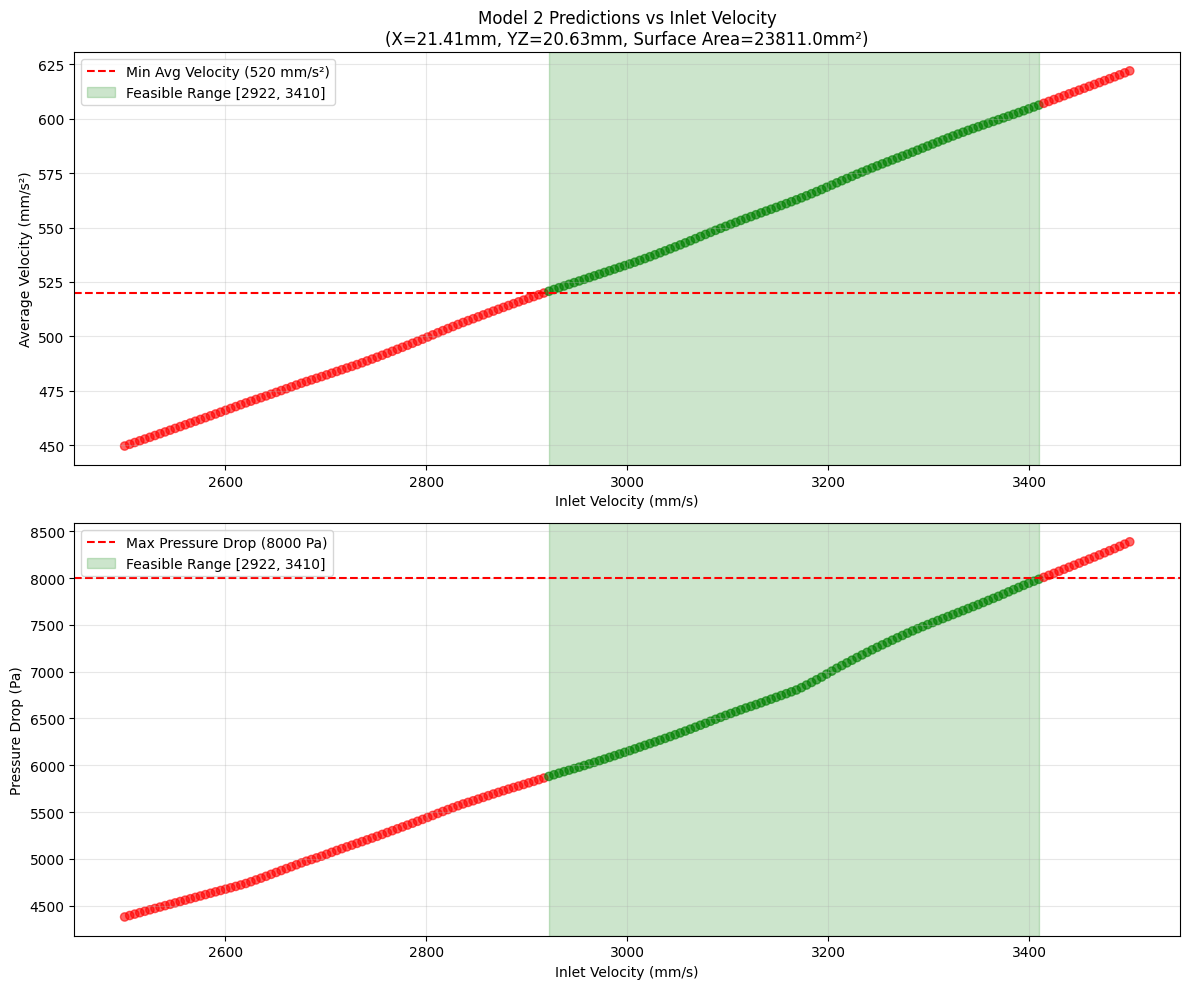

In [46]:
# Two-Stage Optimization Strategy
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution
import pickle

class TwoStageOptimizer:
    def __init__(self, model1, model2):
        # Store references to the two surrogate models
        self.model1 = model1
        self.model2 = model2
        
    def stage1_maximize_surface_area(self):
        """
        Stage 1: Use Model 1 to find optimal X and YZ cell sizes that maximize surface area
        while keeping mass < 125g and staying within input bounds
        """
        print("="*60)
        print("STAGE 1: Optimizing Cell Sizes for Maximum Surface Area")
        print("="*60)
        print("Objective: Maximize Surface Area using Model 1")
        print("Constraints:")
        print("  • 10mm < X Cell Size < 25mm")
        print("  • 10mm < YZ Cell Size < 25mm") 
        print("  • Mass < 125g")
        print()
        
        # Bounds for Stage 1 (only X and YZ cell sizes)
        bounds_stage1 = [(10.0, 25.0), (10.0, 25.0)]
        
        def stage1_objective(params):
            """
            Objective function for Stage 1.
            Returns negative surface area (to maximize it) and applies a heavy penalty if mass > 125g.
            """
            x_cell, yz_cell = params
            
            try:
                # Get Model1 predictions for given cell sizes
                m1_pred = self.model1.predict(x_cell, yz_cell)
                mass = m1_pred["mass"]
                surface_area = m1_pred["surface_area"]
                
                # Heavy penalty if mass constraint violated
                if mass > 125.0:
                    penalty = (mass - 125.0) * 10000  # Heavy penalty
                    return -surface_area + penalty
                else:
                    return -surface_area  # Maximize surface area
                    
            except Exception as e:
                print(f"Error in stage1_objective: {e}")
                return 1e6  # Large penalty for errors
        
        # Try multiple optimization methods for Stage 1
        print("Running Differential Evolution for Stage 1...")
        de_result = differential_evolution(
            stage1_objective,
            bounds_stage1,
            maxiter=500,
            popsize=20,
            seed=42,
            disp=True
        )
        
        print("Running L-BFGS-B from multiple starting points for Stage 1...")
        best_local = None
        best_obj = float('inf')
        
        # Multi-start local search to avoid local minima
        for i in range(20):
            x0 = [np.random.uniform(10, 25), np.random.uniform(10, 25)]
            try:
                local_result = minimize(
                    stage1_objective,
                    x0,
                    method='L-BFGS-B',
                    bounds=bounds_stage1
                )
                if local_result.fun < best_obj:
                    best_obj = local_result.fun
                    best_local = local_result
            except:
                continue
        
        # Choose best result from global or local search
        if de_result.success and (best_local is None or de_result.fun < best_local.fun):
            best_result = de_result
            method_name = "Differential Evolution"
        elif best_local is not None:
            best_result = best_local
            method_name = "L-BFGS-B Multi-start"
        else:
            print("❌ Stage 1 optimization failed!")
            return None, None, None
        
        optimal_x, optimal_yz = best_result.x
        
        # Evaluate the optimal solution using Model 1
        m1_pred = self.model1.predict(optimal_x, optimal_yz)
        optimal_mass = m1_pred["mass"]
        optimal_surface_area = m1_pred["surface_area"]
        
        print(f"\n🎯 STAGE 1 RESULTS ({method_name}):")
        print(f"   Optimal X Cell Size: {optimal_x:.6f} mm")
        print(f"   Optimal YZ Cell Size: {optimal_yz:.6f} mm")
        print(f"   Maximum Surface Area: {optimal_surface_area:.2f} mm²")
        print(f"   Predicted Mass: {optimal_mass:.3f} grams")
        print(f"   Mass constraint satisfied: {'✅' if optimal_mass <= 125 else '❌'}")
        
        if optimal_mass > 125:
            print("⚠️  Warning: Mass constraint not satisfied in Stage 1!")
        
        return optimal_x, optimal_yz, optimal_surface_area
    
    def stage2_find_velocity_range(self, optimal_x, optimal_yz, optimal_surface_area, n_points=100):
        """
        Stage 2: For the optimal cell sizes, find the range of inlet velocities
        that satisfy Model 2 constraints (pressure drop < 8000 Pa, avg velocity > 520 mm/s²)
        """
        print("\n" + "="*60)
        print("STAGE 2: Finding Feasible Inlet Velocity Range")
        print("="*60)
        print(f"Using optimal cell sizes: X={optimal_x:.3f}mm, YZ={optimal_yz:.3f}mm")
        print("Constraints:")
        print("  • 2500 ≤ Inlet Velocity ≤ 3500 mm/s")
        print("  • Pressure Drop < 8000 Pa")
        print("  • Average Velocity > 520 mm/s²")
        print()
        
        # Sweep through inlet velocities in the specified range
        velocities = np.linspace(2500, 3500, n_points)
        results = []
        
        print("Evaluating Model 2 across velocity range...")
        for i, v_inlet in enumerate(velocities):
            try:
                # Get Model2 predictions using optimal cell sizes and current inlet velocity
                m2_pred = self.model2.predict(optimal_x, optimal_yz, v_inlet)
                avg_velocity = m2_pred["avg_velocity"]
                pressure_drop = m2_pred["pressure_drop"]
                
                # Check constraints for feasibility
                pressure_ok = pressure_drop < 8000
                velocity_ok = avg_velocity > 520
                both_ok = pressure_ok and velocity_ok
                
                results.append({
                    'inlet_velocity': v_inlet,
                    'avg_velocity': avg_velocity,
                    'pressure_drop': pressure_drop,
                    'pressure_ok': pressure_ok,
                    'velocity_ok': velocity_ok,
                    'feasible': both_ok
                })
                
            except Exception as e:
                print(f"Error at velocity {v_inlet}: {e}")
                continue
        
        if not results:
            print("❌ No valid predictions obtained!")
            return None, None
        
        # Analyze results to find feasible velocities
        feasible_results = [r for r in results if r['feasible']]
        
        print(f"\n📊 STAGE 2 ANALYSIS:")
        print(f"   Total points evaluated: {len(results)}")
        print(f"   Feasible points: {len(feasible_results)}")
        print(f"   Feasibility rate: {len(feasible_results)/len(results)*100:.1f}%")
        
        if feasible_results:
            feasible_velocities = [r['inlet_velocity'] for r in feasible_results]
            min_feasible = min(feasible_velocities)
            max_feasible = max(feasible_velocities)
            
            print(f"\n✅ FEASIBLE INLET VELOCITY RANGE:")
            print(f"   Minimum: {min_feasible:.1f} mm/s")
            print(f"   Maximum: {max_feasible:.1f} mm/s")
            print(f"   Range width: {max_feasible - min_feasible:.1f} mm/s")
            
            # Pick a recommended solution (middle of feasible range)
            best_result = feasible_results[len(feasible_results)//2]
            
            print(f"\n🎯 RECOMMENDED SOLUTION (middle of feasible range):")
            print(f"   X Cell Size: {optimal_x:.6f} mm")
            print(f"   YZ Cell Size: {optimal_yz:.6f} mm")
            print(f"   Inlet Velocity: {best_result['inlet_velocity']:.1f} mm/s")
            print(f"\n📈 EXPECTED PERFORMANCE:")
            print(f"   Surface Area: {optimal_surface_area:.2f} mm² (from Stage 1)")
            print(f"   Average Velocity: {best_result['avg_velocity']:.2f} mm/s² (> 520 ✅)")
            print(f"   Pressure Drop: {best_result['pressure_drop']:.2f} Pa (< 8000 ✅)")
            
        else:
            print("❌ NO FEASIBLE INLET VELOCITIES FOUND!")
            print("   The optimal cell sizes may not allow any inlet velocity to satisfy constraints")
            
            # Show closest attempts (least constraint violation)
            results_sorted = sorted(results, key=lambda r: (
                max(0, r['pressure_drop'] - 8000) + max(0, 520 - r['avg_velocity'])
            ))
            
            print(f"\n🔍 CLOSEST ATTEMPTS:")
            for i, r in enumerate(results_sorted[:5]):
                pd_viol = max(0, r['pressure_drop'] - 8000)
                vel_viol = max(0, 520 - r['avg_velocity'])
                print(f"   #{i+1}: V_inlet={r['inlet_velocity']:.1f}, PD_violation=+{pd_viol:.1f}Pa, Vel_violation=-{vel_viol:.1f}mm/s²")
        
        return results, feasible_results
    
    def plot_velocity_sweep(self, results, optimal_x, optimal_yz, optimal_surface_area):
        """
        Plot the results of the velocity sweep.
        Shows average velocity and pressure drop vs. inlet velocity, highlighting feasible regions.
        """
        if not results:
            print("No results to plot")
            return
            
        velocities = [r['inlet_velocity'] for r in results]
        avg_velocities = [r['avg_velocity'] for r in results]
        pressure_drops = [r['pressure_drop'] for r in results]
        feasible = [r['feasible'] for r in results]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot 1: Average Velocity vs Inlet Velocity
        colors1 = ['green' if f else 'red' for f in feasible]
        ax1.scatter(velocities, avg_velocities, c=colors1, alpha=0.6)
        ax1.axhline(y=520, color='red', linestyle='--', label='Min Avg Velocity (520 mm/s²)')
        ax1.set_xlabel('Inlet Velocity (mm/s)')
        ax1.set_ylabel('Average Velocity (mm/s²)')
        ax1.set_title(f'Model 2 Predictions vs Inlet Velocity\n(X={optimal_x:.2f}mm, YZ={optimal_yz:.2f}mm, Surface Area={optimal_surface_area:.1f}mm²)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot 2: Pressure Drop vs Inlet Velocity  
        colors2 = ['green' if f else 'red' for f in feasible]
        ax2.scatter(velocities, pressure_drops, c=colors2, alpha=0.6)
        ax2.axhline(y=8000, color='red', linestyle='--', label='Max Pressure Drop (8000 Pa)')
        ax2.set_xlabel('Inlet Velocity (mm/s)')
        ax2.set_ylabel('Pressure Drop (Pa)')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Add feasible region shading
        feasible_velocities = [v for v, f in zip(velocities, feasible) if f]
        if feasible_velocities:
            min_feas = min(feasible_velocities)
            max_feas = max(feasible_velocities)
            ax1.axvspan(min_feas, max_feas, alpha=0.2, color='green', label=f'Feasible Range [{min_feas:.0f}, {max_feas:.0f}]')
            ax2.axvspan(min_feas, max_feas, alpha=0.2, color='green', label=f'Feasible Range [{min_feas:.0f}, {max_feas:.0f}]')
            ax1.legend()
            ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        return fig

def run_two_stage_optimization(m1, m2, plot=True):
    """
    Run the complete two-stage optimization:
    1. Find optimal cell sizes (Stage 1)
    2. Find feasible inlet velocity range (Stage 2)
    3. Optionally plot results
    """
    optimizer = TwoStageOptimizer(m1, m2)
    
    # Stage 1: Find optimal cell sizes
    optimal_x, optimal_yz, optimal_surface_area = optimizer.stage1_maximize_surface_area()
    
    if optimal_x is None:
        print("❌ Stage 1 failed - cannot proceed to Stage 2")
        return None
    
    # Stage 2: Find feasible velocity range  
    results, feasible_results = optimizer.stage2_find_velocity_range(optimal_x, optimal_yz,optimal_surface_area, n_points=200)
    
    if plot and results:
        optimizer.plot_velocity_sweep(results, optimal_x, optimal_yz, optimal_surface_area)
    
    return {
        'optimal_x': optimal_x,
        'optimal_yz': optimal_yz, 
        'optimal_surface_area': optimal_surface_area,
        'velocity_sweep_results': results,
        'feasible_results': feasible_results,
        'optimizer': optimizer
    }

# Integration with existing code
def main_with_two_stage_optimization():
    """
    Run the complete pipeline with two-stage optimization:
    1. Train models (main)
    2. Run two-stage optimization
    """
    # Run the original training
    print("Training models...")
    # Define the file path
    models_file = os.path.join("optimized_models", "trained_models.pkl")

    # Check if the file exists before attempting to load it
    if os.path.exists(models_file):
        # Load the data dictionary from the pickle file
        with open(models_file, 'rb') as f:
            data = pickle.load(f)

        # Extract the models and best result
        m1 = data['model1']
        m2 = data['model2']
        best_result = data['best_result']
        print("Models and best results loaded successfully.")

    else:
        print(f"Error: The file '{models_file}' was not found.")
        # Handle the error, e.g., by training the models instead
        # m1, m2 = main() 
    
    # Run two-stage optimization  
    print("\n" + "="*80)
    print("STARTING TWO-STAGE OPTIMIZATION")
    print("="*80)
    
    optimization_results = run_two_stage_optimization(m1, m2, plot=True)
    
    return m1, m2, optimization_results

# Run the two-stage optimization and store results
m1, m2, opt_results = main_with_two_stage_optimization()